In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import sklearn

from sklearn.model_selection import train_test_split  # Загружаем специальный инструмент для разбивки
from sklearn.preprocessing import StandardScaler  # Загружаем специальный инструмент для стандартизации

# Загрузка Pandas и очистка данных

Первоначальная версия датасета состоит из десяти столбцов, содержащих следующую информацию:

- **Restaurant_id** — идентификационный номер ресторана / сети ресторанов;
- **City** — город, в котором находится ресторан;
- **Cuisine Style** — кухня или кухни, к которым можно отнести блюда, предлагаемые в ресторане;
- **Ranking** — место, которое занимает данный ресторан среди всех ресторанов своего города;
- **Rating** — рейтинг ресторана по данным TripAdvisor (именно это значение должна будет предсказывать модель);
- **Price Range** — диапазон цен в ресторане;
- **Number of Reviews** — количество отзывов о ресторане;
- **Reviews** — данные о двух отзывах, которые отображаются на сайте ресторана;
- **URL_TA** — URL страницы ресторана на TripAdvisor;
- **ID_TA** — идентификатор ресторана в базе данных TripAdvisor.

In [3]:
# Используемые функци

def dummy_cuisine(x, name):
    """Для пребразования типа кухни 
        ресторана в dummy-переменные"""
    
    if name[1:-1] in x:
        return 1
    else:
        return 0
    
def kind_review(x, kind):
    """Подсчитывает количество 
          отзывов заданного типа"""
    
    counter = 0 
    for word in kind:
        if word in str(x).lower():
            counter+=1
        else:
            counter+=0
    return counter

In [4]:
# Загрузим датасеты

df_train = pd.read_csv('main_task.xls')
df_test = pd.read_csv('kaggle_task.csv')
sample_submission = pd.read_csv('sample_submission.csv')

In [5]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['Rating'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями

df = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

In [6]:
# код по очистке данных и генерации новых признаков

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      50000 non-null  object 
 1   City               50000 non-null  object 
 2   Cuisine Style      38410 non-null  object 
 3   Ranking            50000 non-null  float64
 4   Price Range        32639 non-null  object 
 5   Number of Reviews  46800 non-null  float64
 6   Reviews            49998 non-null  object 
 7   URL_TA             50000 non-null  object 
 8   ID_TA              50000 non-null  object 
 9   sample             50000 non-null  int64  
 10  Rating             50000 non-null  float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.2+ MB


In [8]:
# Поменяем названия столбцов
df.columns = ['restaurant_id', 'city', 'cuisine_style', 'ranking', 'price_range',
        'number_of_reviews', 'reviews', 'url_ta', 'id_ta','sample','rating']

## Feature Engeneering

In [9]:
# Сделаем отдельные столбцы для nan
df['number_of_reviews_isNAN'] = pd.isna(df['number_of_reviews']).astype('uint8')
df['price_range_isNAN'] = pd.isna(df['price_range']).astype('uint8')
df['reviews_isNAN'] = pd.isna(df['reviews']).astype('uint8')

In [10]:
# Заменим nan на unknown
df['cuisine_style'].fillna("['unknown']", inplace=True)

In [11]:
# Создатим слов в ревью
review_type = []
for i in df[~df.reviews.isna()].index:
    review_type.extend(df.reviews[i][1:-1].split('], ')[0].replace(' ',',').replace('[','').replace(']','').split(','))
    
# Зададим критерии "хорошего" и "плохого" ревью
good_words = 'good great nice excellent best delicious friendly amazing lovely kind tasty ok pleasant fine'.split(' ')
bad_words = 'bad worst disgusting not undelicious unfriendly'.split(' ')

# Создадим столбец с количеством ревью "хорошего"+ и "плохого"- и "никакого" 0
df['kind_review'] = df['reviews'].apply(kind_review, kind = good_words) - df['reviews'].apply(kind_review, kind = bad_words)
# df['bad_review'] = df['reviews'].apply(kind_review, kind = bad_words)

In [12]:
# Создатим список всех типов кухни
cuisine_type = []
for i in df[~df.cuisine_style.isna()].index:
    cuisine_type.extend(df.cuisine_style[i][1:-1].split(', '))
    
# Создатим список уникальных типов кухни
cuisine = list(pd.Series(cuisine_type).unique())

# Создадим dummy-переменные типов кухни
for name in cuisine:
    df[name[1:-1]] = df['cuisine_style'].apply(dummy_cuisine, name = name)

In [13]:
df = pd.get_dummies(df, columns=['city'])

In [14]:
df.replace(to_replace='$', value=1, inplace=True)
df.replace(to_replace='$$ - $$$', value=2, inplace=True)
df.replace(to_replace='$$$$', value=3, inplace=True)
df.price_range.fillna(0, inplace=True)

## Анализ полученных признаков

In [15]:
df.head(3)

,restaurant_id,cuisine_style,ranking,price_range,number_of_reviews,reviews,url_ta,id_ta,sample,rating,...,city_Munich,city_Oporto,city_Oslo,city_Paris,city_Prague,city_Rome,city_Stockholm,city_Vienna,city_Warsaw,city_Zurich
0,id_0,"['Bar', 'Pub']",12963.0,2.0,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918,0,0.0,...,0,0,0,1,0,0,0,0,0,0
1,id_1,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,2.0,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944,0,0.0,...,0,0,0,0,0,0,0,0,0,0
2,id_2,['Vegetarian Friendly'],810.0,2.0,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638,0,0.0,...,0,0,0,0,0,0,0,0,0,0


In [16]:
df.describe()

,ranking,price_range,number_of_reviews,sample,rating,number_of_reviews_isNAN,price_range_isNAN,reviews_isNAN,kind_review,Bar,...,city_Munich,city_Oporto,city_Oslo,city_Paris,city_Prague,city_Rome,city_Stockholm,city_Vienna,city_Warsaw,city_Zurich
count,50000.000000,50000.000000,46800.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,...,50000.000000,50000.000000,50000.00000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,3664.427520,1.184880,124.471197,0.800000,3.194430,0.064000,0.347220,0.000040,0.789480,0.108220,...,0.022900,0.012840,0.00976,0.122160,0.036320,0.051780,0.020660,0.028860,0.018500,0.013700
std,3700.092452,0.957308,294.114345,0.400004,1.705453,0.244755,0.476091,0.006324,0.884476,0.310661,...,0.149586,0.112585,0.09831,0.327474,0.187087,0.221585,0.142245,0.167415,0.134752,0.116244
min,1.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-2.000000,0.000000,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,972.000000,0.000000,9.000000,1.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2278.000000,1.000000,33.000000,1.000000,4.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,5241.000000,2.000000,115.000000,1.000000,4.500000,0.000000,1.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,16444.000000,3.000000,9660.000000,1.000000,5.000000,1.000000,1.000000,1.000000,5.000000,1.000000,...,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


<AxesSubplot:>

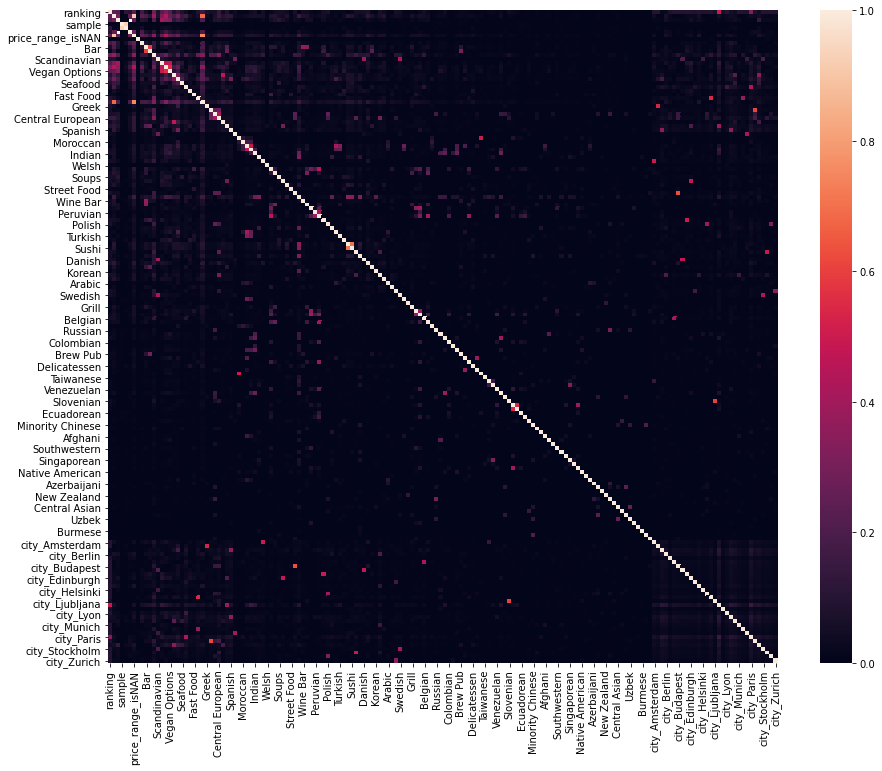

In [17]:
plt.figure(figsize=(15,12))
sns.heatmap(df.corr().abs())

<AxesSubplot:>

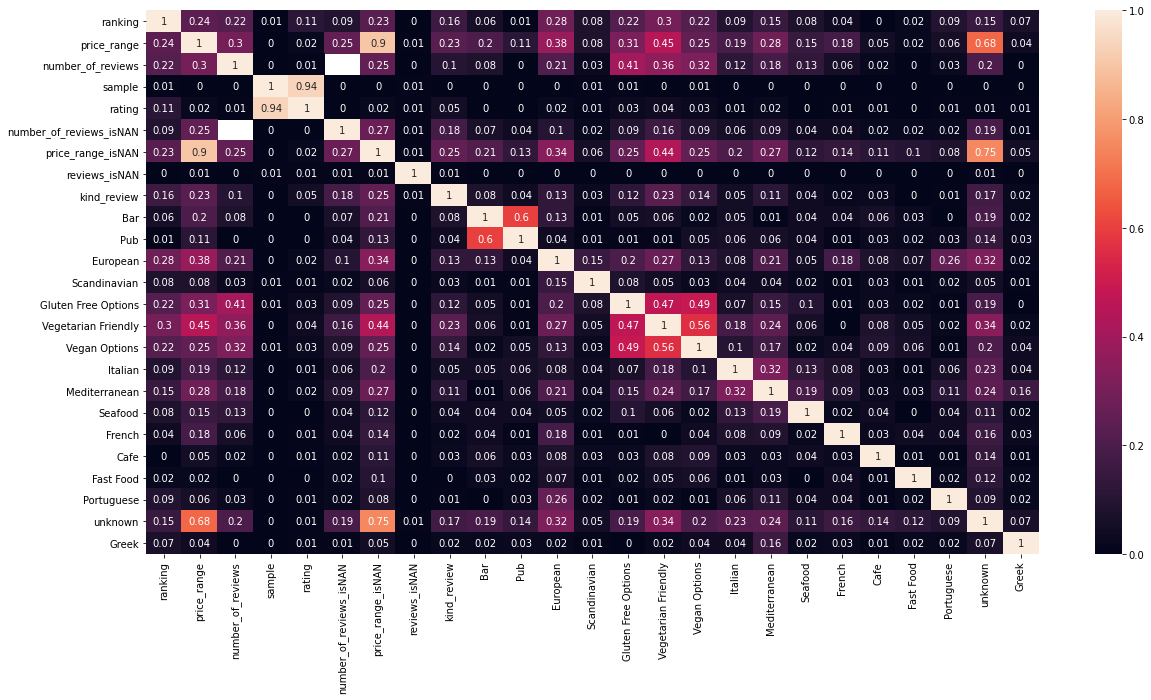

In [18]:
plt.figure(figsize=(20,10))
sns.heatmap(df[df.columns[:30]].corr().abs().round(2), annot=True)

Большая корреляция имеется между 
- **rating & sample** - 0.94, но так как sample искусственный признак и в регресси не учавствует, то это не важно.
- **price_range & price_range_isNAN** - 0.9, но удалять мы ничего не будем, так price_range_isNAN несет информаци. о пропущенных значениях.

Остальные корреляции тоже в расчет принимать не будем.

In [19]:
df_corr = df.corr()

In [20]:
df_corr.rating[df_corr.rating.abs()>0.3]

sample    0.936543
rating    1.000000
Name: rating, dtype: float64

In [21]:
df = pd.get_dummies(df,'restaurant_id')

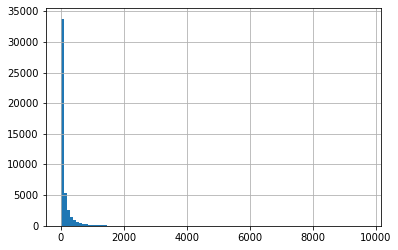

In [22]:
df.number_of_reviews.hist(bins=100);

In [23]:
df.number_of_reviews.value_counts(ascending=False).head(10)

2.0     2403
3.0     2042
4.0     1707
5.0     1471
6.0     1258
7.0     1126
8.0     1026
9.0      966
10.0     854
11.0     807
Name: number_of_reviews, dtype: int64

In [24]:
df.number_of_reviews.min()

2.0

Очень много ресторанов с малым количеством отзывов.

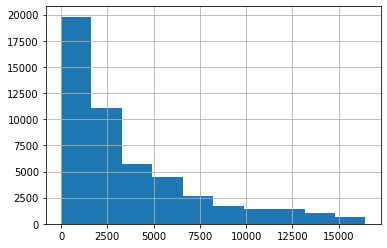

In [25]:
df.ranking.hist();

# Разбиваем датафрейм на части, необходимые для обучения и тестирования модели

In [26]:
df.fillna(0, inplace=True)

In [27]:
# Теперь выделим тестовую часть
train_data = df.query('sample == 1').drop(['sample'], axis=1)
test_data = df.query('sample == 0').drop(['sample'], axis=1)

In [28]:
del df

In [29]:
# Х - данные с информацией о ресторанах, у - целевая переменная (рейтинги ресторанов)
X = train_data.drop(['rating'], axis = 1)
y = train_data['rating']

In [30]:
# X.fillna(0, inplace=True)

In [31]:
# Наборы данных с меткой "train" будут использоваться для обучения модели, "test" - для тестирования.
# Для тестирования мы будем использовать 25% от исходного датасета.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [32]:
std = StandardScaler()
col_names = ['ranking','price_range','number_of_reviews', 'kind_review']
std.fit(X_train.loc[:,col_names])
X_train.loc[:,col_names] = std.transform(X_train.loc[:,col_names])
X_test.loc[:,col_names] = std.transform(X_test.loc[:,col_names])

/home/azarodnyuk/.conda/envs/azar_env/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/home/azarodnyuk/.conda/envs/azar_env/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


# Создаём, обучаем и тестируем модель

In [33]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [34]:
X_train.shape

(30000, 165773)

In [35]:
# Создаём модель
regr = RandomForestRegressor(n_estimators=100, n_jobs=20)

# Обучаем модель на тестовом наборе данных
regr.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = regr.predict(X_test)

In [36]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.201763


In [37]:
# MAE: 0.212829
# 0.20127949999
# 0.200782

## Готовим Submission

In [38]:
# Создаем тестовый датасет
x_test = test_data.drop(['rating'], axis = 1)
# x_test.fillna(0, inplace=True)

# Приводим его стандартному виду
x_test.loc[:,col_names] = std.transform(x_test.loc[:,col_names])

# Делаем предсказание
sub_pred = regr.predict(x_test)

In [39]:
# Добавляем предсзание в submission-датасет
sample_submission.Rating = sub_pred

In [40]:
# Сохраняем в формате csv
sample_submission.to_csv('sample_submission.csv', index=False)

In [41]:
# pd.read_csv('sample_submission.csv')

**Выводы:** метрику удалось улучшить не очень сильно - в пределах 0.1. 

Среди возможных идей для дальнейшего улучшения значения метрики  можно было бы попробовать следующее:

- собрать данные о количестве ресторанов в каждом городе, чтобы признак **ranking** сделать более репрезентативным
- собрать больше комментариев с сайта и их дальнейшей сортировки на "плохие" и "хорошие"
- возможно, стоило бы еще сделать анализ комментариев по времени, то есть - тренд: "улучшение или "ухудшение"

Из менее важного, возможно:
- определить возраст ресторана
- определить удаленность от центра города